In [1]:
# IMPORT
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

# DATALOADER
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset-v2/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
class_names = train_dataset.classes

# FID
import subprocess

def get_fid():
    com_a = "python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 16"
    com_b = "python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 16"
    fid_nm = float(subprocess.check_output(com_a, shell=False)[:-3])
    fid_wm = float(subprocess.check_output(com_b, shell=False)[:-3])
    
    return fid_nm, fid_wm

In [2]:
# Model
latent_dim = 100
n_classes = 2

# G
class DCGANGenerator(nn.Module):
    def __init__(self):
        super(DCGANGenerator, self).__init__()
        self.label_embed = nn.Embedding(n_classes, n_classes)
        self.init_size = 4
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# D 
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    def forward(self, img, labels):
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

In [3]:
# PARAMETERS

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

dcgan_generator = DCGANGenerator()
dcgan_generator.cuda()
dcgan_generator.apply(weights_init_normal)

dcgan_discriminator = DCGANDiscriminator()
dcgan_discriminator.cuda()
dcgan_discriminator.apply(weights_init_normal)

adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

lr = 0.0001

optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
# Experiment

NAME_EXP = "Dv2_N"
epoch_tot = 0
fid_sum_min = 1000.0
interveal_ = 10
lst_fid_nm = []
lst_fid_wm = []
lst_epoch = []

In [13]:
N_EPOCHS = 100

start_time = time.time()

for _ in range(N_EPOCHS):
    for idx_, (imgs, labels) in enumerate(train_dataloader):
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0)
        real_imgs = imgs.cuda()
        labels = labels.cuda()
        
        # train G
        optimizer_G.zero_grad()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_imgs = dcgan_generator(z, generated_labels)
        g_loss = adversarial_loss(dcgan_discriminator(generated_imgs, generated_labels), real)
        g_loss.backward()
        optimizer_G.step()
        
        # train D
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(dcgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(dcgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
    
    print("E{:>03} - L_D : {:>4.2f}, L_G : {:>4.2f} | TE : {:>6.1f}m".format(
        epoch_tot, 
        d_loss.item(), 
        g_loss.item(), 
        (time.time()-start_time)/60)
          ,end="")
    epoch_tot += 1
    
    if not epoch_tot % interveal_:
        for i in range(10):
            z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
            generated_labels = torch.cuda.IntTensor(100).fill_(0)
            generated_imgs = dcgan_generator(z, generated_labels)
            for j in range(100):
                save_image(generated_imgs.data[j], f'./results/dcgan/with_mask/{i * 100 + j}.png', normalize=True)
        for i in range(10):
            z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
            generated_labels = torch.cuda.IntTensor(100).fill_(1)
            generated_imgs = dcgan_generator(z, generated_labels)
            for j in range(100):
                save_image(generated_imgs.data[j], f'./results/dcgan/without_mask/{i * 100 + j}.png', normalize=True)
        
        fid_nm, fid_wm = get_fid()
        fid_sum = fid_nm + fid_wm
        if fid_sum < fid_sum_min:
            fid_sum_min = fid_sum
            str_ = "./models/{}-E{:>03}-SUM{:>3}".format(NAME_EXP, epoch_tot, int(fid_sum_min))
            torch.save(dcgan_generator.state_dict(), str_ + "-G.pt")
            torch.save(dcgan_discriminator.state_dict(), str_ + "-D.pt")
        
        lst_fid_nm.append((epoch_tot, fid_nm))
        lst_fid_wm.append((epoch_tot, fid_wm))
        print(" FID_NM: {:>6.2f}, FID_WM: {:>6.2f}, SUM: {:>6.2f}".format(fid_nm, fid_wm, fid_sum))
    else:
        print()

E050 - L_D : 0.22, L_G : 0.36 | TE:   0.9m
E051 - L_D : 0.28, L_G : 0.16 | TE:   1.8m
E052 - L_D : 0.26, L_G : 0.33 | TE:   2.7m
E053 - L_D : 0.19, L_G : 0.22 | TE:   3.6m
E054 - L_D : 0.22, L_G : 0.29 | TE:   4.4m
E055 - L_D : 0.25, L_G : 0.34 | TE:   5.3m
E056 - L_D : 0.25, L_G : 0.42 | TE:   6.2m
E057 - L_D : 0.16, L_G : 0.40 | TE:   7.1m
E058 - L_D : 0.23, L_G : 0.27 | TE:   8.0m
E059 - L_D : 0.25, L_G : 0.28 | TE:   8.9m FID_NM: 151.09, FID_WM:  78.84, SUM: 229.93
E060 - L_D : 0.19, L_G : 0.36 | TE:  10.7m
E061 - L_D : 0.22, L_G : 0.35 | TE:  11.6m
E062 - L_D : 0.23, L_G : 0.35 | TE:  12.5m
E063 - L_D : 0.20, L_G : 0.28 | TE:  13.4m
E064 - L_D : 0.18, L_G : 0.26 | TE:  14.3m
E065 - L_D : 0.19, L_G : 0.36 | TE:  15.2m
E066 - L_D : 0.20, L_G : 0.33 | TE:  16.1m
E067 - L_D : 0.20, L_G : 0.38 | TE:  17.0m
E068 - L_D : 0.29, L_G : 0.25 | TE:  17.9m
E069 - L_D : 0.24, L_G : 0.46 | TE:  18.7m FID_NM: 152.25, FID_WM:  69.22, SUM: 221.48
E070 - L_D : 0.22, L_G : 0.21 | TE:  20.6m
E071 - L_

In [6]:
import pandas as pd
import numpy as np
df_ = pd.DataFrame()
df_['epoch'] = lst_epoch
df_['with_mask'] = lst_fid_wm
df_['without_mask'] = lst_fid_nm
df_['total'] = df_['with_mask'] + df_['without_mask']
str_ = './' + NAME_EXP + '-R.csv'
df_.to_csv(str_, index=False)

ValueError: Length of values (0) does not match length of index (15)

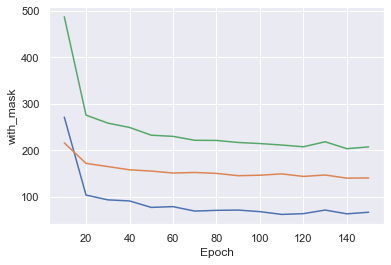

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

str_ = './' + NAME_EXP + '-R.csv'
df_ = pd.read_csv(str_)

sns.set(style='darkgrid')
sns.lineplot(x='epoch', y='with_mask', data=df_)
sns.lineplot(x='epoch', y='without_mask', data=df_)
sns.lineplot(x='epoch', y='total', data=df_)

plt.show()

In [ ]:
from IPython.display import Image as Display

for i in range(10):
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    generated_imgs = dcgan_generator(z, generated_labels
    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/with_mask/{i * 100 + j}.png', normalize=True)

for i in range(10):
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    generated_imgs = dcgan_generator(z, generated_labels)
    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/without_mask/{i * 100 + j}.png', normalize=True)

In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 16

In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 16

In [ ]:
# ./results/custom/ 폴더의 모든 파일을 results.zip라는 이름으로 압축
!zip ./results.zip -r ./results/custom/*